## Imports and definitions

In [1]:
import sys, os, glob, time, requests, json
from time import time, strftime
from tqdm import tqdm, trange

import numpy as np
from numpy.random import *
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import folium
from folium import plugins, Map, CircleMarker

In [2]:
dataDir = '../data/'
configDir = '../config/'
buildDir = '../build/'

## Visualize data

In [3]:
df = pd.read_csv(os.path.join(dataDir, 'trips-pivot.csv'), index_col='id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488 entries, 72 to 3242
Data columns (total 15 columns):
name           488 non-null object
latitude       488 non-null float64
longitude      488 non-null float64
dep_count      488 non-null int64
dep_mean       488 non-null float64
dep_min        488 non-null int64
dep_max        488 non-null int64
dep_median     488 non-null float64
arr_count      488 non-null int64
arr_mean       488 non-null float64
arr_min        488 non-null int64
arr_max        488 non-null int64
arr_median     488 non-null float64
statusValue    488 non-null object
totalDocks     488 non-null int64
dtypes: float64(6), int64(7), object(2)
memory usage: 61.0+ KB


In [4]:
df['dep_total_time'] = df.dep_count * df.dep_mean
df['arr_total_time'] = df.dep_count * df.dep_mean
df['dep_time_rel'] = df.dep_total_time / df.totalDocks
df['arr_time_rel'] = df.dep_total_time / df.totalDocks
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488 entries, 72 to 3242
Data columns (total 19 columns):
name              488 non-null object
latitude          488 non-null float64
longitude         488 non-null float64
dep_count         488 non-null int64
dep_mean          488 non-null float64
dep_min           488 non-null int64
dep_max           488 non-null int64
dep_median        488 non-null float64
arr_count         488 non-null int64
arr_mean          488 non-null float64
arr_min           488 non-null int64
arr_max           488 non-null int64
arr_median        488 non-null float64
statusValue       488 non-null object
totalDocks        488 non-null int64
dep_total_time    488 non-null float64
arr_total_time    488 non-null float64
dep_time_rel      488 non-null float64
arr_time_rel      488 non-null float64
dtypes: float64(10), int64(7), object(2)
memory usage: 76.2+ KB


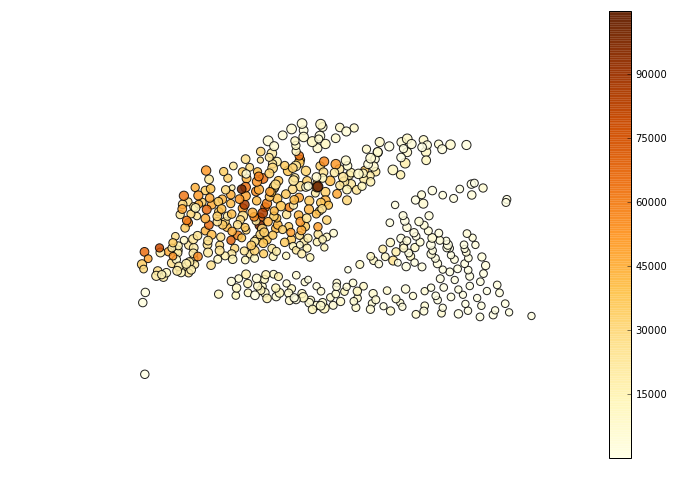

In [5]:
quantity1 = 'dep_count'
quantity2 = 'totalDocks'
maxValue = df[quantity2].max()

plt.rc('figure', figsize=(12, 8))

plt.axis('off')
scatterPlot = plt.scatter(df.longitude.values, df.latitude.values,
                          s=100*np.sqrt(df[quantity2]/maxValue), alpha=0.85,
                          cmap='YlOrBr', c=df[quantity1].values)
plt.colorbar(scatterPlot)
plt.show()

In [22]:
# set main quantity to visualize
quantity1 = 'dep_mean'
quantity2 = 'totalDocks'

minValue1 = float(df[quantity1].min())
maxValue1 = float(df[quantity1].max())
minValue2 = float(df[quantity2].min())
maxValue2 = float(df[quantity2].max())

df.sort(quantity1, ascending=True, inplace=True)

# access to custom tiles
apiKeyFile = os.path.join(configDir, 'api-key.txt')
if os.path.isfile(apiKeyFile):
    API_token = np.loadtxt(apiKeyFile, dtype=str)
    tileset = 'https://api.mapbox.com/v4/tckh.pmj1j8f2/{z}/{x}/{y}.png' + \
        '?access_token={API_token}'.format(API_token=API_token)
else:
    tileset = 'Open Street Map'
    
# choose color scheme
cmap = plt.get_cmap('plasma')

# create folium map
centerLocation = [df.latitude.median(), df.longitude.median()]
nycMap = Map(centerLocation, zoom_start=13, tiles=tileset, attr='tckh | folium | MapBox')

# add markers
def addMarker(bikeStation):
    location = [bikeStation.latitude, bikeStation.longitude]
    color = matplotlib.colors.rgb2hex(cmap(bikeStation[quantity1]/maxValue1))
    radius = 150 * np.sqrt(bikeStation[quantity2]/maxValue2)
    popup = bikeStation['name'] + \
        '; # of docks: ' + str(bikeStation.totalDocks) + \
        '; mean ride time: ' + str(bikeStation.dep_mean / 60)
    CircleMarker(location,
                 radius=radius,
                 color=color,
                 fill_color=color,
                 fill_opacity=0.65,
                 popup=popup
                ).add_to(nycMap)

df.apply(addMarker, axis=1)

nycMap.create_map(os.path.join(buildDir, 'bikes-usage-map.html'))

nycMap

In [25]:
df2 = df.copy()
df2['diff'] = df2.dep_count - df2.arr_count
# df2 = df2[df2['diff'] > df2.totalDocks.max()]

df2['diff_rel'] = df2['diff'] / df2.dep_count

# set main quantity to visualize
quantity1 = 'dep_time_rel'
quantity2 = 'totalDocks'

minValue1 = float(df2[quantity1].min())
maxValue1 = float(df2[quantity1].max())
minValue2 = float(df2[quantity2].min())
maxValue2 = float(df2[quantity2].max())

df2.sort(quantity1, ascending=True, inplace=True)

# access to custom tiles
apiKeyFile = os.path.join(configDir, 'api-key.txt')
if os.path.isfile(apiKeyFile):
    API_token = np.loadtxt(apiKeyFile, dtype=str)
    tileset = 'https://api.mapbox.com/v4/tckh.pmj1j8f2/{z}/{x}/{y}.png' + \
        '?access_token={API_token}'.format(API_token=API_token)
else:
    tileset = 'Open Street Map'
    
# choose color scheme
cmap = plt.get_cmap('plasma')

# create folium map
centerLocation = [df2.latitude.median(), df2.longitude.median()]
nycMap = Map(centerLocation, zoom_start=13, tiles=tileset, attr='tckh | folium | MapBox')

# add markers
def addMarker(bikeStation):
    location = [bikeStation.latitude, bikeStation.longitude]
    color = matplotlib.colors.rgb2hex(cmap((bikeStation[quantity1] - minValue1)/(maxValue1 - minValue1)))
    radius = 150 * np.sqrt(bikeStation[quantity2]/maxValue2)
    popup = bikeStation['name'] + \
        '; # of docks: ' + str(bikeStation.totalDocks) + \
        '; # of departures: ' + str(bikeStation.dep_count) + \
        '; # of arrivals: ' + str(bikeStation.arr_count) + \
        '; total ride count (dep): ' + str(bikeStation.dep_total_time / 3600) + \
        '; total ride time per dock (dep): ' + str(bikeStation.dep_time_rel / 86400)
    CircleMarker(location,
                 radius=radius,
                 color=color,
                 fill_color=color,
                 fill_opacity=0.65,
                 popup=popup
                ).add_to(nycMap)

df2.apply(addMarker, axis=1)

nycMap.create_map(os.path.join(buildDir, 'bikes-difference-map.html'))

nycMap

In [16]:
s = ''
for color in np.linspace(0.0, 1.0, 11):
    s += '"{}", '.format(matplotlib.colors.rgb2hex(cmap(color)))
print s

"#0d0887", "#41049d", "#6a00a8", "#8f0da4", "#b12a90", "#cc4778", "#e16462", "#f2844b", "#fca636", "#fcce25", "#f0f921", 


In [19]:
df.head()

,name,latitude,longitude,dep_count,dep_mean,dep_min,dep_max,dep_median,arr_count,arr_mean,arr_min,arr_max,arr_median,statusValue,totalDocks,dep_total_time,arr_total_time,dep_time_rel,arr_time_rel
id,,,,,,,,,,,,,,,,,,,
3097,N Henry St & Richardson St,40.719216,-73.942447,3025,518.300496,60,19399,249.0,2895,507.608981,60,18111,266.0,In Service,19,1.567859e+06,1.567859e+06,82518.894737,82518.894737
239,Willoughby St & Fleet St,40.691966,-73.981302,9679,521.038020,60,18215,348.0,8913,476.416583,60,19071,321.0,In Service,31,5.043127e+06,5.043127e+06,162681.516129,162681.516129
270,Adelphi St & Myrtle Ave,40.693083,-73.971789,11612,541.735446,60,20249,347.0,11109,571.705734,60,19414,385.0,In Service,23,6.290632e+06,6.290632e+06,273505.739130,273505.739130
3086,Graham Ave & Conselyea St,40.715143,-73.944507,5169,575.147611,61,18563,347.0,5352,540.347160,60,19286,309.5,In Service,25,2.972938e+06,2.972938e+06,118917.520000,118917.520000
3242,Schermerhorn St & Court St,40.691029,-73.991834,15,583.066667,197,1483,395.0,23,820.565217,262,2957,643.0,In Service,39,8.746000e+03,8.746000e+03,224.256410,224.256410
